# SEM-EDS zinc-soap dataset: data preparation

This notebook performs one-time setup:
- Extract .raw.gz files
- Load .rpl/.raw spectrum images with HyperSpy
- Apply crop + axis calibration + metadata
- Save cleaned datasets as .hspy for fast reload in the analysis notebook

After running this notebook once, proceed to '02_clustering_analysis.ipynb' for all analysis. 

In [1]:
# Imports
from pathlib import Path
import gzip, shutil
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

# Paths (edit if your folder structure differs)
DATA = Path("./data_raw")
OUT = Path("./data_processed")
FIGS = Path("./figures")

OUT.mkdir(exist_ok=True)
FIGS.mkdir(exist_ok=True)

print("DATA:", DATA.resolve())
print("OUT:", OUT.resolve())
print("FIGS:", FIGS.resolve())

# Plot defaults
plt.rcParams["figure.dpi"] = 120
DEFAULT_CMAP = "magma"

DATA: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\data_raw
OUT: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\data_processed
FIGS: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\figures


## 1) Extract .raw.gz (if needed)

In [2]:
def gunzip_if_needed(gz_path: Path) -> Path: 
    """Extract *raw.gz to *raw if the raw file is not already present."""
    raw_path = gz_path.with_suffix("")
    if raw_path.exists():
        print(f"[skip] {raw_path.name} already exists")
        return raw_path

    if not gz_path.exists():
        raise FileNoteFoundError(gz_path)

    print(f"[do] Extracting {gz_path.name} -> {raw_path.name}")
    with gzip.open(gz_path, "rb") as f_in, open(raw_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    return raw_path

aerial_raw = gunzip_if_needed(DATA / "Aerial 150x.raw.gz")
cs_raw = gunzip_if_needed(DATA / "CS 148x.raw.gz")

print("Done.")

[skip] Aerial 150x.raw already exists
[skip] CS 148x.raw already exists
Done.


## 2) Load Aerial dataset, crop empty rows, set metadata, save .hspy

In [3]:
aerial_rpl = DATA / "Aerial 150x.rpl"
sA = hs.load(aerial_rpl).inav[:, :600] # crop bottom empty pixels

# Spatial calibration
sA.axes_manager[0].name  = "x"
sA.axes_manager[0].scale = 0.859
sA.axes_manager[0].units = "µm"

sA.axes_manager[1].name  = "y"
sA.axes_manager[1].scale = 0.8859
sA.axes_manager[1].units = "µm"

# Energy calibration
sA.axes_manager[2].name   = "Energy"
sA.axes_manager[2].offset = -0.955
sA.axes_manager[2].scale  = 0.01
sA.axes_manager[2].units  = "keV"

# EDS signal type + elements
sA.set_signal_type("EDS_SEM")
sA.add_elements(["C","Cl","Zn","O","Cd","S"])
sA.metadata.General.title = "Aerial EDS Spectrum Image"

aerial_hspy = OUT / "Aerial 150x.hspy"
sA.save(aerial_hspy, overwrite=True)
print("Saved:", aerial_hspy)
print(sA)

C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\hyperspy\misc\_utils.py:1590: VisibleDeprecationWarning: Importing `LazyComplexSignal1D` from `hyperspy._signals.complex_signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(
C:\Users\elise\miniforge3\envs\zincsoap-ml\lib\site-packages\hyperspy\misc\_utils.py:1590: VisibleDeprecationWarning: Importing `LazySignal1D` from `hyperspy._signals.signal1d` is deprecated and will be removed in the HyperSpy 3.0 release. Import it from `hyperspy.signals` instead.
  warnings.warn(


Saved: data_processed\Aerial 150x.hspy
<EDSSEMSpectrum, title: Aerial EDS Spectrum Image, dimensions: (1024, 600|3093)>


## 3) Load Cross-section dataset, crop empty rows, set metadata, save .hspy

In [4]:
cs_rpl = DATA / "CS 148x.rpl"
sC = hs.load(cs_rpl).inav[:, 120:]   # crop bottom empty pixels

# Spatial calibration
sC.axes_manager[0].name  = "x"
sC.axes_manager[0].scale = 0.859
sC.axes_manager[0].units = "µm"

sC.axes_manager[1].name  = "y"
sC.axes_manager[1].scale = 0.8859
sC.axes_manager[1].units = "µm"

# Energy calibration
sC.axes_manager[2].name   = "Energy"
sC.axes_manager[2].offset = -0.955
sC.axes_manager[2].scale  = 0.01
sC.axes_manager[2].units  = "keV"

# EDS signal type + elements
sC.set_signal_type("EDS_SEM")
sC.add_elements(["C","Cl","Zn","O","Cd","S"])
sC.metadata.General.title = "Cross-section EDS Spectrum Image"

cs_hspy = OUT / "CS 148x.hspy"
sC.save(cs_hspy, overwrite=True)
print("Saved:", cs_hspy)
print(sC)

Saved: data_processed\CS 148x.hspy
<EDSSEMSpectrum, title: Cross-section EDS Spectrum Image, dimensions: (1024, 648|3144)>


## 4) Quick inspection plots (optional)

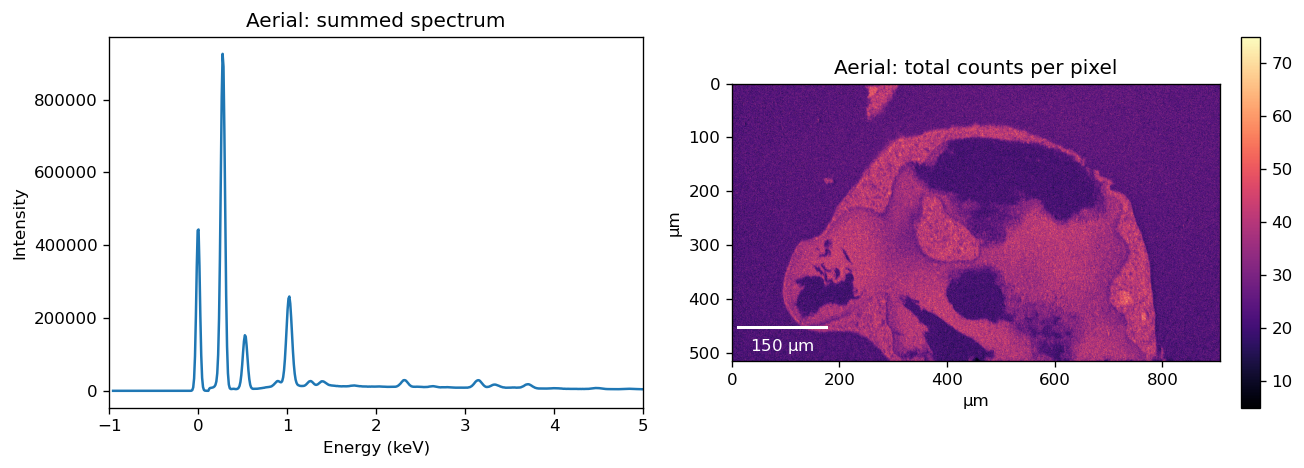

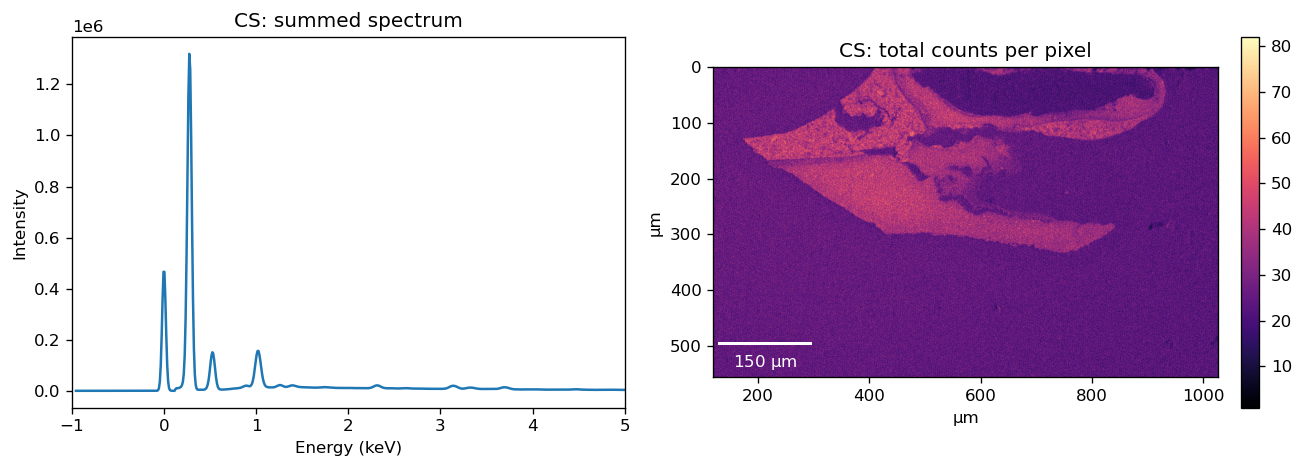

In [11]:
from matplotlib_scalebar.scalebar import ScaleBar

def quick_inspect(s, label, xlim_keV=(0, 5)):
    """
    Quick verification visualization (single figure, side-by-side):
    Left: summed spectrum (display cropped)
    Right: total counts per pixel (physically scaled + scalebar)
    """

    sum_spec = s.sum(axis=(0, 1))
    total_counts = s.sum(axis=2)

    # HyperSpy axes: 0=Y, 1=X, -1=energy
    y_ax = s.axes_manager[0]
    x_ax = s.axes_manager[1]
    e_ax = sum_spec.axes_manager[-1]

    ny, nx = total_counts.data.shape

    # Physical extent from metadata
    x0 = x_ax.offset
    x1 = x_ax.offset + x_ax.scale * nx
    y0 = y_ax.offset
    y1 = y_ax.offset + y_ax.scale * ny
    extent = [x0, x1, y1, y0]

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))

    # ---- Summed spectrum ----
    energy = e_ax.axis
    axes[0].plot(energy, sum_spec.data)
    axes[0].set_xlim(*xlim_keV)
    axes[0].set_title(f"{label}: summed spectrum")
    axes[0].set_xlabel(f"Energy ({e_ax.units})")
    axes[0].set_ylabel("Intensity")

    # ---- Total counts map ----
    im = axes[1].imshow(
        total_counts.data,
        cmap=DEFAULT_CMAP,
        extent=extent,
        origin="upper",
        aspect="equal"
    )

    axes[1].set_title(f"{label}: total counts per pixel")
    axes[1].set_xlabel(f"{x_ax.units}")
    axes[1].set_ylabel(f"{y_ax.units}")

    # Add scale bar using metadata pixel size
    scalebar = ScaleBar(
        x_ax.scale,
        x_ax.units,
        location='lower left',
        color='white',
        box_alpha=0
    )
    axes[1].add_artist(scalebar)

    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

quick_inspect(sA, "Aerial", xlim_keV=(-1,5))
quick_inspect(sC, "CS", xlim_keV=(-1,5))